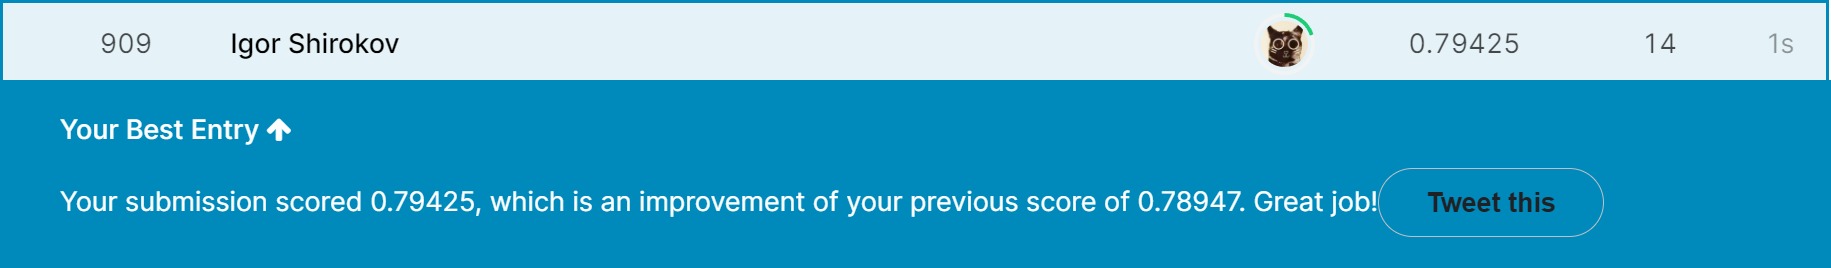

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn import preprocessing, linear_model
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.ensemble import VotingClassifier

from scipy.stats import norm

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Functions Declaration

In [2]:
# Find family_name and family_name from Name
def Name_func(row):
    # discard the excess before the beginning of the line   
    row = row.replace('van ', '')
    row = row.replace('del ', '')
    row = row.replace('de ', '')
    row = row.replace('the ', '')
    # Find family name
    split_1 = row.split(sep=', ', maxsplit=1)
    family_name = split_1[0]
    # Find title
    split_2 = split_1[1].split(sep=' ')
    title = split_2[0]
    return [title, family_name]

In [3]:
# Fill NaN
def replace_func(df):
    df.replace({"Embarked" : {np.nan : "C"}}, inplace = True)

    # Find how age depends from title, Pclass and SibSp    
    median_age_grouped = df[df['Age'].isna() == False].groupby(['title', 'Pclass', 'SibSp'])['Age']
    median_age_grouped = pd.DataFrame(0.7 * (median_age_grouped.median()+median_age_grouped.min()) ).reset_index()
    
    for index, row in df.iterrows():
        if np.isnan(row['Age']):
            # filter by title           
            sub_row = median_age_grouped[df.loc[index, 'title'] == median_age_grouped['title']]
                            
            # filter by SibSp
            if df.loc[index, 'SibSp'] not in list(sub_row['SibSp']):
                # use closest SibSp instead               
                lst = np.asarray(sub_row['SibSp'])
                idx = (np.abs(lst - df.loc[index, 'SibSp'])).argmin()
                argmax_SibSps = lst[idx]
                sub_row = sub_row[argmax_SibSps == sub_row['SibSp']]
            else:
                sub_row = sub_row[df.loc[index, 'SibSp'] == sub_row['SibSp']]
                
            # filter by Pclass
            if df.loc[index, 'Pclass'] not in list(sub_row['Pclass']):
                # use closest Pclass instead               
                lst = np.asarray(sub_row['Pclass'])
                idx = (np.abs(lst - df.loc[index, 'Pclass'])).argmax()
                argmax_Pclass = lst[idx]
                sub_row = sub_row[argmax_Pclass == sub_row['Pclass']]
            else:
                sub_row = sub_row[df.loc[index, 'Pclass'] == sub_row['Pclass']]
            
            # And finally define missing Age value
            df.loc[index, 'Age'] = sub_row['Age'].item()
            
    return df

In [4]:
# Create additional features and shape existing ones
def EDA_func(df):
    # Do bucketing with Age
    bins1 = [0, 1, 18, 26, 36, 55, 65, np.infty]
    
    labels1 = ['infant','teenager','young', 'mature1', 'mature2', 'old', 'very_old']
    df['group_Age'] = pd.cut(df.Age, bins=bins1, labels=labels1).copy()
    
    # Do bucketing with Fare
    # bins2 = [0, df[df.Fare !=0]['Fare'].min(), 10, 20, 70, np.infty]
    bins2 = [-1, train[train.Fare !=0]['Fare'].min()-0.1, 7.5, 8, 13.5, 25, 40, 80, np.infty]
    
    # People who have Fare = 0 are probably the ship's crew
    labels2 = ['staff' ,'poor', 'average1', 'average2', 'average3','rich', 'very_rich', 'vip']
    df['group_Fare'] = pd.cut(df.Fare, bins=bins2, labels=labels2).copy()
    
    # Put passengers below 10 year old in the list   
    df.loc[df['Age']<=10, 'title'] = df[df['Age']<=10]['title'].apply(lambda x: 'Kid')
    
    return df

In [5]:
# Function to drop unneeded features
def drop_list(df):
    # Drop usless features
    df.drop(columns='Name', inplace=True)
    df.drop(columns='Ticket', inplace=True)
    # df.drop(columns='Fare', inplace=True)
    # df.drop(columns='Embarked', inplace=True)
    # df.drop(columns='SibSp', inplace=True)
    # df.drop(columns='Parch', inplace=True)  
    # Drop Cabin - too many NaN
    df.drop(columns='Cabin', inplace=True)
    
    return df

# Import Data Set

In [6]:
# load train df and drop duplicates
train = pd.read_csv('train.csv')
train.drop_duplicates()
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Exploratory Data Analysis

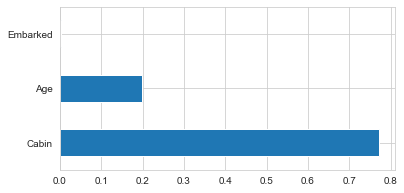

In [8]:
# Show NaN as % of missing values in the column
plt.figure(figsize=(6,3))
sns.set_style("whitegrid")
is_null_list = train.isna().sum() / len(train)
is_null_list.sort_values(ascending=False, inplace=True)
is_null_list[is_null_list > 0].plot.barh()
plt.show()

In [9]:
# Find NaN in Embarked column
train[train['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [10]:
# Fair of this 2 survived passengers is big ($80), so they probably embarked in C
train.groupby(['Embarked', 'Pclass'])['Fare'].median()

Embarked  Pclass
C         1         78.2667
          2         24.0000
          3          7.8958
Q         1         90.0000
          2         12.3500
          3          7.7500
S         1         52.0000
          2         13.5000
          3          8.0500
Name: Fare, dtype: float64

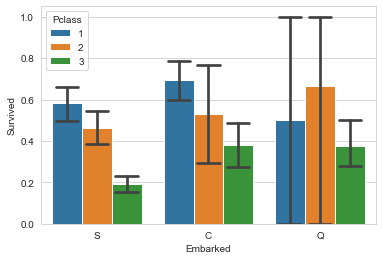

In [11]:
# PLot Embarked
ax = sns.barplot(data=train, x="Embarked", y="Survived", hue="Pclass", capsize=.2)
plt.show()

In [12]:
# Most passengers from Q was from 2 and 3 class
train.groupby(['Embarked', 'Pclass'])['Survived'].count()

Embarked  Pclass
C         1          85
          2          17
          3          66
Q         1           2
          2           3
          3          72
S         1         127
          2         164
          3         353
Name: Survived, dtype: int64

In [13]:
# Find family name and title
train[['title','family_name']] = list(train['Name'].apply(Name_func))

In [14]:
# Check what NaN we have inside title
train[train['Age'].isna()].groupby(['Age', 'title'], dropna=False)['Sex'].count()

Age  title  
NaN  Dr.          1
     Master.      4
     Miss.       36
     Mr.        119
     Mrs.        17
Name: Sex, dtype: int64

In [15]:
# Because we have too many NaN in Age column, let's see the distribution before apply any algorithm
train_no_na = train[['Age','Survived']].dropna()

loc1, scale1 = norm.fit(train_no_na.Age)
r_norm = norm.rvs(loc1, scale1, size=10000)

In [16]:
# See how many titles for passengers with age below 10
train[train['Age']<10].groupby(['title', 'Pclass'])['Age'].count()

title    Pclass
Master.  1          2
         2          9
         3         21
Miss.    1          1
         2          8
         3         21
Name: Age, dtype: int64

In [17]:
# Replace NaN
train = replace_func(train)

In [18]:
# Check NaN. We will drop Cabin in the next chapter because the is too many NaN
is_null_list = train.isna().sum() / len(train)
is_null_list[is_null_list>0]

Cabin    0.771044
dtype: float64

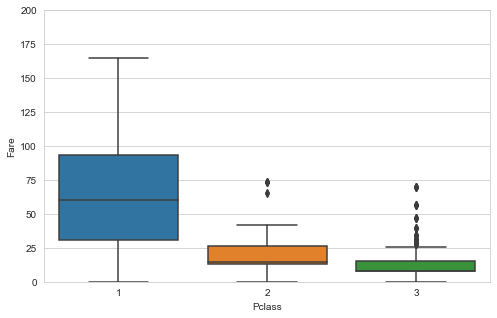

In [19]:
# Let's see how Fare connected with Placass
plt.figure(figsize=(8,5))
sns.boxplot(data=train, y='Fare', x='Pclass')
plt.ylim(0,200)
plt.show()

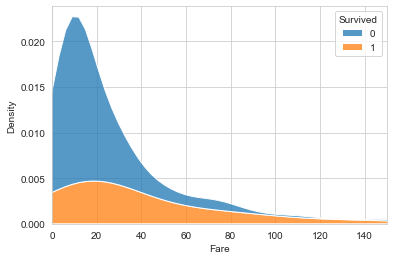

In [20]:
# Fare and Survivability rate
sns.kdeplot(x=train.Fare, hue=train.Survived, multiple="stack")
plt.xlim(0,150)
plt.show()

In [21]:
# Age and Survivability rate
bins = [-1, train[train.Fare !=0]['Fare'].min()-0.1, 7.5, 8, 13.5, 25, 40, 80, np.infty]
train.groupby(pd.cut(train.Fare, bins)).mean()['Survived']

Fare
(-1.0, 3.912]    0.066667
(3.912, 7.5]     0.152778
(7.5, 8.0]       0.259740
(8.0, 13.5]      0.291667
(13.5, 25.0]     0.419355
(25.0, 40.0]     0.436709
(40.0, 80.0]     0.549020
(80.0, inf]      0.770270
Name: Survived, dtype: float64

In [22]:
# Age and Survivability rate
bins = [0, 1, 18, 26, 35, 55, 65, np.infty]
train.groupby(pd.cut(train.Age, bins)).mean()['Survived']

Age
(0.0, 1.0]      0.857143
(1.0, 18.0]     0.496855
(18.0, 26.0]    0.329787
(26.0, 35.0]    0.327465
(35.0, 55.0]    0.401961
(55.0, 65.0]    0.382353
(65.0, inf]     0.125000
Name: Survived, dtype: float64

In [23]:
# We will group title with 1 im separate bin
train.groupby('title')['Survived'].mean()

title
Capt.        0.000000
Col.         0.500000
Countess.    1.000000
Don.         0.000000
Dr.          0.428571
Jonkheer.    0.000000
Lady.        1.000000
Major.       0.500000
Master.      0.575000
Miss.        0.697802
Mlle.        1.000000
Mme.         1.000000
Mr.          0.156673
Mrs.         0.792000
Ms.          1.000000
Rev.         0.000000
Sir.         1.000000
Name: Survived, dtype: float64

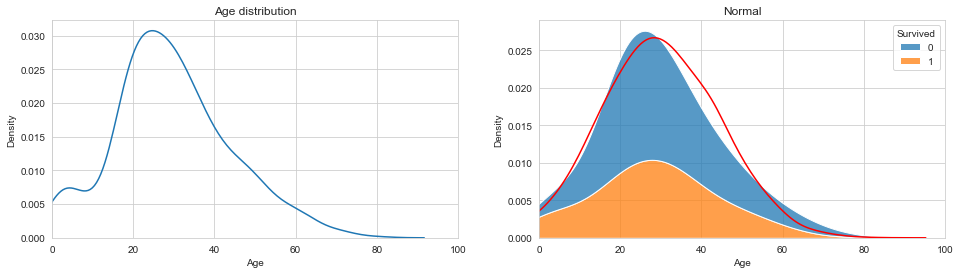

In [24]:
# See how Age affect Survivability before fillNaN
fig, axes = plt.subplots(1, 2, figsize=(16,4), sharex=True)

sns.kdeplot(data=r_norm, ax=axes[1], bw_adjust=1.5, color='red')

sns.kdeplot(x=train_no_na.Age, ax=axes[0])
sns.kdeplot(x=train_no_na.Age, hue=train_no_na.Survived,
            multiple="stack", bw_adjust=1.5, ax=axes[1])

axes[0].set_title('Age distribution')
axes[1].set_title('Normal')
plt.xlim(0,100)
plt.show()

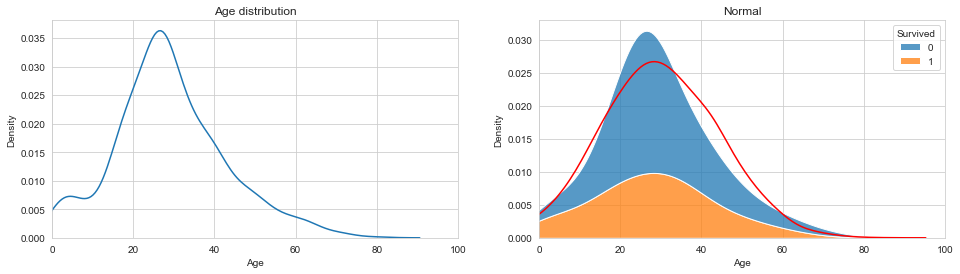

In [25]:
# See how Age affect Survivability after fillNaN
fig, axes = plt.subplots(1, 2, figsize=(16,4), sharex=True)

sns.kdeplot(data=r_norm, ax=axes[1], bw_adjust=1.5, color='red')

sns.kdeplot(x=train.Age, ax=axes[0])
sns.kdeplot(x=train.Age, hue=train.Survived, multiple="stack", bw_adjust=1.5, ax=axes[1])

axes[0].set_title('Age distribution')
axes[1].set_title('Normal')
plt.xlim(0,100)
plt.show()

As we can see distribution slightly changed, but it's acceptable.

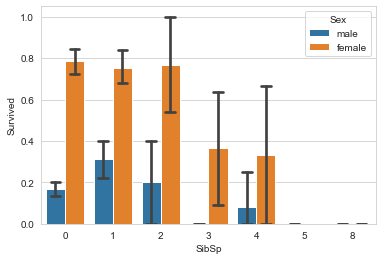

In [26]:
# Drow number of siblings / spouses aboard the Titanic
ax = sns.barplot(data=train, x="SibSp", y="Survived", hue="Sex", capsize=.2)
plt.show()

In [27]:
train[train['SibSp']>2].groupby(['SibSp', 'Sex'])['Age'].count()

SibSp  Sex   
3      female    11
       male       5
4      female     6
       male      12
5      female     1
       male       4
8      female     3
       male       4
Name: Age, dtype: int64

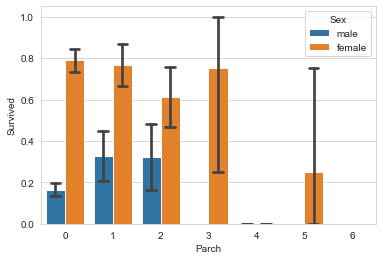

In [28]:
# Drow number of parents / children aboard the Titanic
ax = sns.barplot(data=train, x="Parch", y="Survived", hue="Sex", capsize=.2)
plt.show()

In [29]:
train[train['Parch']>2].groupby(['Parch', 'Sex'])['Age'].count()

Parch  Sex   
3      female    4
       male      1
4      female    2
       male      2
5      female    4
       male      1
6      female    1
Name: Age, dtype: int64

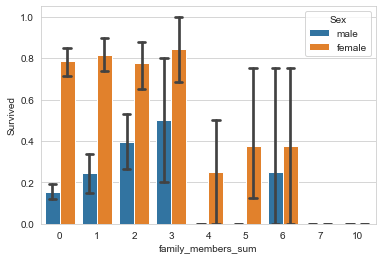

In [30]:
# Let's see how sum family on board affect survivability
train['family_members_sum'] = train['SibSp'] + train['Parch']
ax = sns.barplot(data=train, x="family_members_sum", y="Survived", hue="Sex", capsize=.2)
plt.show()

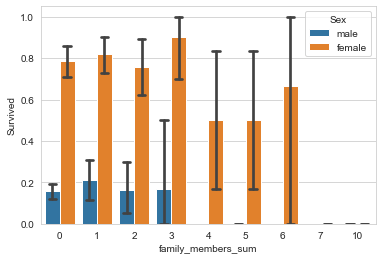

In [31]:
# And the same plot for Age > 10
train['family_members_sum'] = train['SibSp'] + train['Parch']
ax = sns.barplot(data=train[train['Age']>15], x="family_members_sum", y="Survived", hue="Sex", capsize=.2)
plt.show()

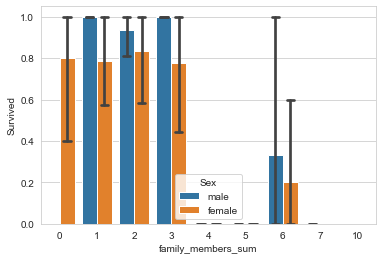

In [32]:
# And the same plot for Age <= 10
train['family_members_sum'] = train['SibSp'] + train['Parch']
ax = sns.barplot(data=train[train['Age']<=15], x="family_members_sum", y="Survived", hue="Sex", capsize=.2)
plt.show()

# Model Development | Preparations

In [33]:
# load df's
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# Drop the  'PassengerId' colum since it's unnecessary for the prediction process
train.drop(['PassengerId'], axis=1, inplace=True)
test.drop(['PassengerId'], axis=1, inplace=True)

In [34]:
# Drop row where Fare is too high for the Pclass
train.drop(index=train[(train['Pclass'] == 3) & (train['Fare']>30)].index, inplace=True)

In [35]:
# Define features and target variable
y = train.Survived.reset_index(drop=True)
train_features = train.drop('Survived', axis=1)
test_features = test
features = train_features.append(test_features, sort=False)
features.reset_index(inplace=True)
features = features.drop('index', axis=1)
features.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Apply functions

In [36]:
features[['title','family_name']] = list(features['Name'].apply(Name_func))
features = replace_func(features)

In [37]:
# Let's group some titles
remap_title_dict = {
    'Mr.': 'Mr.',
    'Miss.': 'Miss.',
    'Mrs.': 'Mrs.',
    'Capt.': 'Capt.',
    'Countess.': 'Countess.',
    
    'Sir.': 'Mr.',
    'Don.': 'Mr.',
    
    'Mlle.': 'Miss.',
    'Ms.': 'Miss.',
    'Mme.': 'Miss.',
    'Lady.': 'Mrs.',
    'Dona.': 'Mrs.',
}
features.title = features.title.map(remap_title_dict)
features['title'] = features['title'].replace(np.nan, 'Other')

In [38]:
# Check NaN
is_null_list = features.isna().sum() / len(features)
is_null_list[is_null_list>0]

Fare     0.000789
Cabin    0.767350
dtype: float64

In [39]:
# Find NaN in Embarked column
features[features['Fare'].isna()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title,family_name
1002,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,Mr.,Storey


In [40]:
features['Fare'] = features['Fare'].replace(np.nan, 8)

In [41]:
features = EDA_func(features)

In [42]:
# We use the numpy fuction log1p which applies log(1+x) to all elements of the column
features["Age"] = np.log1p(features["Age"])
features["Fare"] = np.log1p(features["Fare"])

In [43]:
features = drop_list(features)

In [44]:
features.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,title,family_name,group_Age,group_Fare
0,3,male,3.135494,1,0,2.110213,S,Mr.,Braund,young,poor
1,1,female,3.663562,1,0,4.280593,C,Mrs.,Cumings,mature2,very_rich
2,3,female,3.295837,0,0,2.188856,S,Miss.,Heikkinen,young,average1
3,1,female,3.583519,1,0,3.990834,S,Mrs.,Futrelle,mature1,very_rich
4,3,male,3.583519,0,0,2.202765,S,Mr.,Allen,mature1,average2


In [45]:
# Separate families with 5+ numbers in additional column
families = features.groupby('family_name')['family_name'].count()
families = list(families[families<5].index)
features['family_name'] = features['family_name'].apply(lambda x: x if x in families else 'Big_family')

In [46]:
features.groupby('title')['Sex'].count().sort_values(ascending=False)

title
Mr.          744
Miss.        206
Mrs.         194
Kid           92
Other         30
Capt.          1
Countess.      1
Name: Sex, dtype: int64

In [47]:
# Get dummies
final_features = pd.get_dummies(features,).reset_index(drop=True)
X = final_features.iloc[:len(train), :]
X_sub = final_features.iloc[len(y):, :]
X.shape

(850, 887)

In [48]:
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)

In [49]:
X = X.drop(overfit, axis=1).copy()
X_sub = X_sub.drop(overfit, axis=1).copy()

In [50]:
X.shape

(850, 675)

# Model Development | Final Estimation and Prediction

In [51]:
# Sclit the data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=38)

## Classifiers

In [52]:
c1 = LogisticRegression(C=3, solver='liblinear', random_state=38)
pipe = Pipeline([('RobustScaler', preprocessing.RobustScaler()), ('clf', c1)])
cv = cross_validate(pipe, X_train, y_train, cv=5, n_jobs=-1)
cv['test_score']

array([0.83088235, 0.88970588, 0.84558824, 0.84558824, 0.80147059])

In [53]:
c2 = GradientBoostingClassifier(n_estimators=1000, random_state=38)
pipe = Pipeline([('RobustScaler', preprocessing.RobustScaler()), ('clf', c2)])
cv = cross_validate(pipe, X_train, y_train, cv=5, n_jobs=-1)
cv['test_score']

array([0.83088235, 0.89705882, 0.85294118, 0.875     , 0.81617647])

In [54]:
c3 = AdaBoostClassifier(n_estimators=120, random_state=38)
pipe = Pipeline([('RobustScaler', preprocessing.RobustScaler()), ('clf', c3)])
cv = cross_validate(pipe, X_train, y_train, cv=5, n_jobs=-1)
cv['test_score']

array([0.80882353, 0.85294118, 0.84558824, 0.86029412, 0.82352941])

In [55]:
c4 = BaggingClassifier(n_estimators=65, max_features=int(len(X.columns)*0.5), random_state=38)
pipe = Pipeline([('RobustScaler', preprocessing.RobustScaler()), ('clf', c4)])
cv = cross_validate(pipe, X_train, y_train, cv=5, n_jobs=-1)
cv['test_score']

array([0.82352941, 0.89705882, 0.84558824, 0.84558824, 0.82352941])

In [56]:
c5 = RandomForestClassifier(random_state=38, criterion='entropy')
pipe = Pipeline([('RobustScaler', preprocessing.RobustScaler()), ('clf', c5)])
cv = cross_validate(pipe, X_train, y_train, cv=5, n_jobs=-1)
cv['test_score']

array([0.83088235, 0.88970588, 0.86029412, 0.83823529, 0.80882353])

In [57]:
# Final Voting Classifier
v_cla = VotingClassifier([
    ('c1', c1),
    ('c2', c2),
    # ('r3', r3),
    ('c4', c4),
    ('c5', c5),
], voting='hard', weights=[1.2,1,1,1]) #weights=[1.2,1]

In [58]:
# Form a pipeline
pipe = Pipeline([
    ('RobustScaler', preprocessing.RobustScaler()),
    ('classifier', v_cla)
])

In [59]:
cv = cross_validate(pipe, X, y, cv=5, n_jobs=-1)
cv['test_score']

array([0.85882353, 0.82941176, 0.83529412, 0.81176471, 0.85294118])

In [60]:
# Make a prediction
target_variable = pipe.fit(X, y).predict(X_sub)

# Save results

In [61]:
prediction = pd.DataFrame()

index_n = np.linspace(892, 1309, 418)
prediction['PassengerId'] = index_n
prediction['PassengerId'] = prediction['PassengerId'].astype('int')

In [62]:
prediction['Survived'] = target_variable.astype('int')

In [63]:
# Check the predicted results with real ones
df_solved = pd.read_csv("real_titanic.csv")
df_solved = df_solved[['Name', 'Survived']]
test = pd.read_csv('test.csv')
test = test.sort_values('Name')
test['Name'] = test['Name'].map(lambda x: x.replace('.',''))
df_solved['Name'] = df_solved['Name'].map(lambda x: x.replace('.',''))

result = pd.merge(test, df_solved, how="left", on="Name")
result = pd.merge(result, prediction, how="left", on="PassengerId")

res = len(result[(result['Survived_x']!=result['Survived_y']) & (result['Survived_x'].isna() == False)]) /len(result[result['Survived_x'].isna() == False])
print(f'% of incorrect predictions: {res:.1%}')

% of incorrect predictions: 17.5%


In [64]:
file_name = 'Prediction-' + str(datetime.date.today()) + '.csv'
pd.DataFrame(prediction).to_csv(file_name, index=False)
print('Saved!')

Saved!
